# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assume Gaussian magnitude error but ignore period error and metallicity. but that Cepheids scatter off the period-luminosity relation because Gaussian intrinsic dispersion $\sigma_{\text{int}}$

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee, scipy
import scipy.stats as st
import astropy.cosmology as pycos
import corner
from emcee import autocorr

In [113]:
exec(open('./cepheids.py').read())
ceph = Cepheids('./R11ceph.dat')
hosts = ceph.list_hosts()

In [115]:
#Use matrix for the model (Riess et al. 2009 eq.3 y=L*q)

#make L

m_L = np.zeros((np.shape(ceph.data)[0], np.shape(ceph.data)[0]+1)) #make array
#set diag values as 1
m_L[:sum(ceph.data[:, 1]!=4258), :sum(ceph.data[:, 1]!=4258)] = np.diag(np.ones(sum(ceph.data[:, 1]!=4258)))
m_L[:, -2] = np.ones(np.shape(ceph.data)[0]) #11111
m_L[:, -1] = np.log10(ceph.data[:, 4]) #logP

In [120]:
np.shape(m_L)

(646, 647)

In [116]:
# make q
thosts = list(ceph.data[:, 1])
hosts_ord = np.ones(len(hosts))
n_rp = np.ones(len(hosts)+1, dtype=int)

j=0
for i in range(len(hosts)):
    n_rp[i] = thosts.count(thosts[i+j])
    hosts_ord[i] = thosts[i+j]
    j += n_rp[i]

In [117]:
def mw_arr(theta):
    m_q = np.repeat(theta, n_rp)[:, np.newaxis] #change to (N+1,1)
    model = np.matmul(m_L, m_q)
    return model

In [118]:
yy = ceph.data[:, 2][:, np.newaxis] #m_obs
cov = np.diag(ceph.data[:, 3]**2) #sigma
icov = np.linalg.inv(cov) #inv cov

In [119]:
def likelihood(theta):
    yy = ceph.data[:, 2][:, np.newaxis]
    
    #Riess 2009 et al. eq 4
    chi2 = np.matmul(np.matmul((yy-mw_arr(theta)).T, icov), (yy-mw_arr(theta)))
    return -0.5*chi2[0][0]

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [153]:
# set priors for each galaxy assuming flat LCDM cosmology
# use distance modulus

cos = pycos.FlatLambdaCDM(H0=70, Om0=0.3)
#distance modulus: 5log(D_L)-25, using 25 to use Mpc scale
dm = lambda zz: 5*np.log10(cos.luminosity_distance(zz).value)+25

dmu = np.zeros(len(hosts)-1) #excluding 4258, total of 8
smu = np.zeros(len(hosts)-1) #sigma
for i, host in enumerate(hosts_ord[:-1]):
    ceph.select(str(int(host)))
    dmu[i] = dm(ceph.redshifts[str(int(host))]) - dm(ceph.redshifts['4258'])
    # smu[i] = np.max(ceph.sigma)
    smu[i] = dmu[i]*0.1 #assume 10% error

def prior(theta):
    dmu4536, dmu4639, dmu3370, dmu3982, dmu3021, dmu1309, dmu5584, dmu4038, zp4258, bw = theta
    if 25<zp4258<30: #uniform prior
        pr_gs = st.norm.pdf(theta[:-2], dmu, smu)
        pr_bw = st.norm.pdf(bw, -3.23, 0.11)
        return np.sum(pr_gs) + 9*pr_bw
    else:
        return -np.inf

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

In [154]:
def probability(theta):
    dmu4536, dmu4639, dmu3370, dmu3982, dmu3021, dmu1309, dmu5584, dmu4038, zp4258, bw = theta
    pr = prior(theta)
    if not np.isfinite(pr):
        return -np.inf
    return pr+likelihood(theta)

In [155]:
xinit = [*dmu, 27, -3.2]
pos = xinit + np.random.randn(30, len(xinit))
nwalkers, ndim = pos.shape #(30,10)

sampler = emcee.EnsembleSampler(nwalkers, ndim, probability)
sampler.run_mcmc(pos, 10000, progress=True)

State([[ 1.50527175  2.2907447   2.66490338  2.15596349  2.88184906  3.14269524
   2.26556251  2.07029695 26.18675579 -2.89363345]
 [ 1.43992863  2.22821438  2.70629004  2.21450663  2.82925897  3.1636167
   2.2889664   2.1203296  26.26310448 -2.94628499]
 [ 1.47778592  2.32567525  2.64873355  2.31978691  2.77432071  3.10171674
   2.23405579  1.96931751 26.17228668 -2.88452592]
 [ 1.4949389   2.20704046  2.67145635  2.20263878  2.81068736  3.13769187
   2.34960284  2.19035578 26.60726195 -3.1658934 ]
 [ 1.50414118  2.20813399  2.63503395  2.26890305  2.89483656  3.07954345
   2.21540259  2.11646095 26.09029739 -2.83309062]
 [ 1.49545007  2.24630738  2.71307606  2.16584429  2.77455507  3.12963338
   2.31266959  2.12290122 26.60671442 -3.17031193]
 [ 1.51912399  2.27118761  2.67738686  2.22490645  2.87990694  3.08333814
   2.2458165   2.03905895 26.27248315 -2.93977287]
 [ 1.4953032   2.44633292  2.66066198  2.19908357  3.01564025  3.059451
   2.26730888  2.08224301 26.06660808 -2.8144968

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.

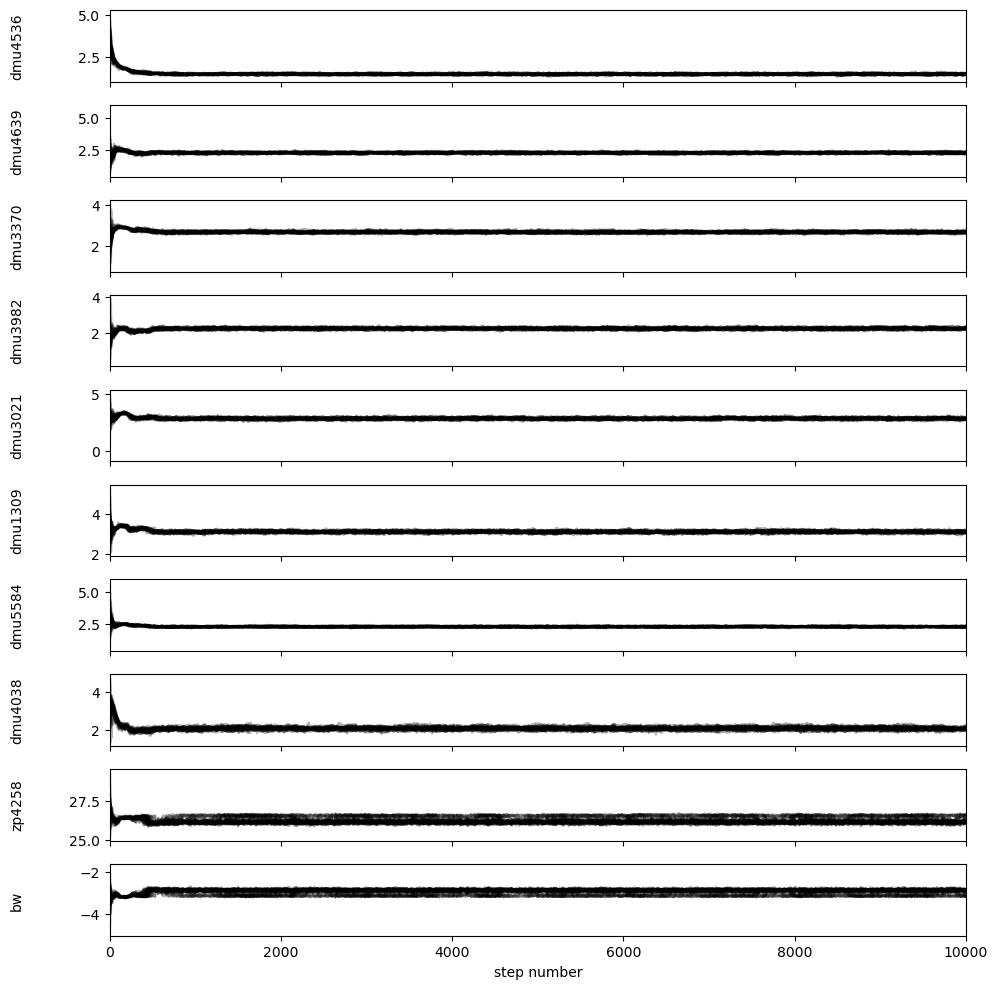

In [156]:
### plotting results
fig, axes = plt.subplots(10, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ['dmu4536', 'dmu4639', 'dmu3370', 'dmu3982', 'dmu3021', 'dmu1309', 'dmu5584', 'dmu4038', 'zp4258', 'bw']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

In [157]:
flat_samples = sampler.get_chain(discard=1000, thin=10, flat=True)

corner.corner(flat_samples, quantiles=[0.16,0.5,0.84],labels=labels)
plt.show()

In [158]:
#median and error for each parameters

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

In [159]:
pf = np.median(flat_samples,axis=0)

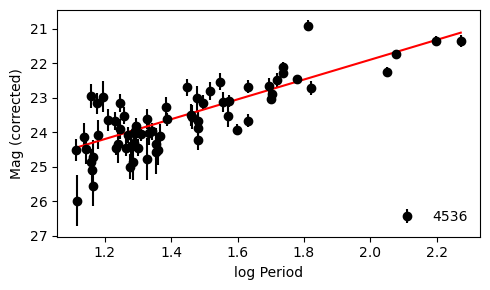

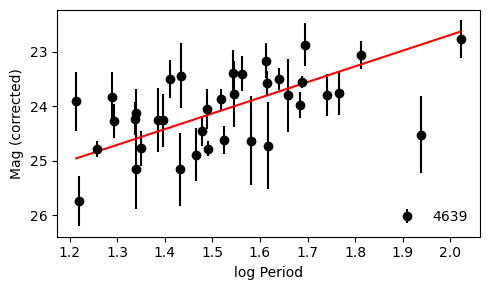

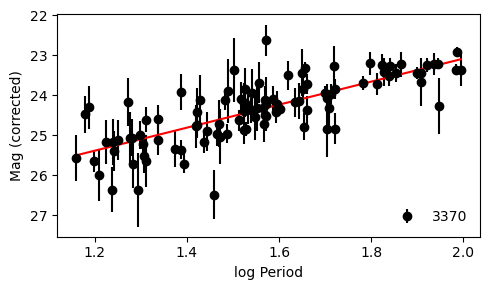

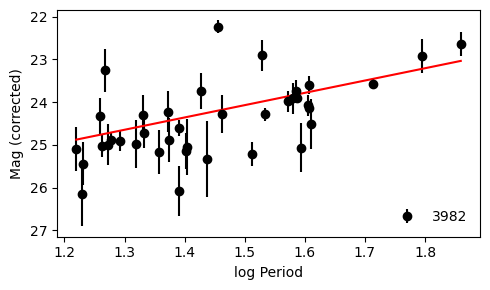

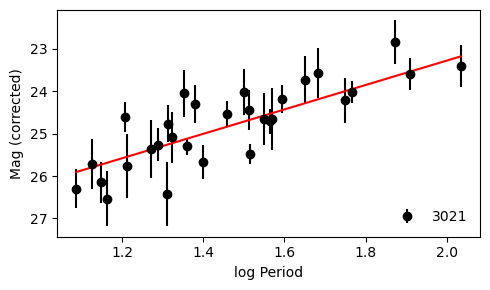

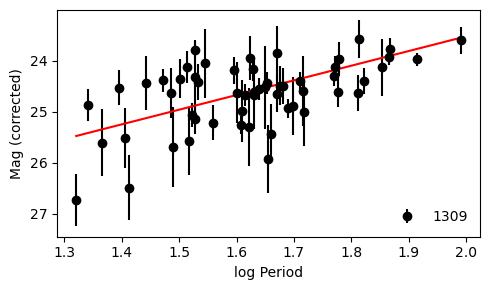

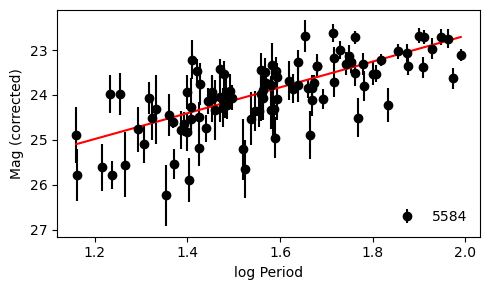

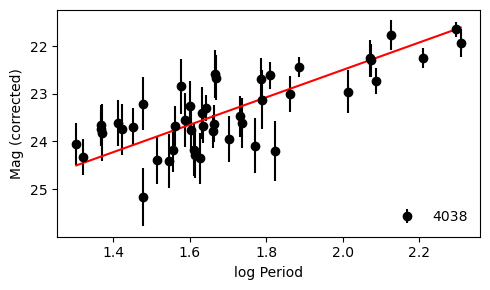

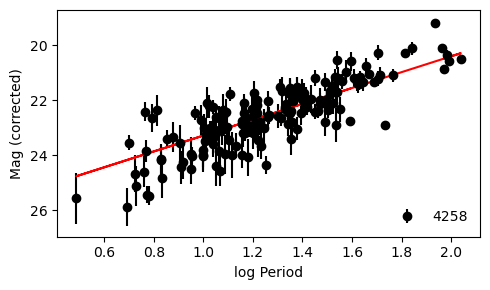

In [160]:
ym = np.hstack(mw_arr(pf))

j=0
for i, host in enumerate(hosts_ord):
    ceph.select(str(int(host)))
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    %matplotlib inline
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label=str(int(host)),color='k')
    ax.plot(logP, ym[j:j+len(logP)],color='r')
    j+=len(logP)
    ax.legend(frameon=False,loc=4)
    ax.set_xlabel('log Period')
    ax.set_ylabel('Mag (corrected)')
    ax.invert_yaxis()
    fig.tight_layout()
    plt.show()

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

$$
log H_{0} = \frac{(m^{0}_{v,4258}-\mu_{0,4258}) + 5a_{v} + 25}{5}
$$

$$
m^{0}_{v,i} = (\mu_{0,i}-\mu_{0,4258}) + m^{0}_{v,4258}
$$

$$
log H_{0} = \frac{(m^{0}_{v,i} - (\mu_{0,i}-\mu_{0,4258}) - \mu_{0,4258}) + 5a_{v} + 25}{5}
$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [164]:
SN_ma = np.array([15.147, 16.040, 16.545, 15.593, 16.699, 16.678, 16.274, 15.901]) #mi+5av
ceph_dmu = pf[:-2] #mu difference

mu_4258 = 5*np.log10(7.60)+25 #from Humphreys
# 7.60 / 0.17 / 0.15

logH0 = (SN_ma-ceph_dmu-mu_4258+25)/5
print(logH0)
print(np.mean(10**logH0))
print(np.median(10**logH0))
print(np.std(10**logH0))

[1.85090731 1.87033825 1.89384546 1.79313241 1.88473972 1.83248938
 1.91954232 1.88098544]
73.66978857165023
75.10943114605006
6.109445900764393
